In [1]:
import gymnasium as gym
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import copy
import keyboard
from time import sleep
from matplotlib import pyplot as plt
from easydict import EasyDict as edict

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class ActorCritic(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.actor_Net= nn.Sequential(nn.Conv2d(3, 5, 5, stride=1, bias=True), #(92x92x5)
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),  #(46x46x5)
                                      nn.Conv2d(5, 10, 5, stride=1, bias=True), #(in_ch, out_ch, kernel_size) #(42x42x10)
                                      nn.ReLU(),
                                      nn.MaxPool2d(3), #(kernel_size) #(14,14,10)
                                      nn.Flatten(start_dim=1), #by def only flatens dim starting from 1
                                      nn.Linear(1960, 500),
                                      nn.ReLU(),
                                      nn.Linear(500, 6)) #(input, output)
        
        self.critic_Net= nn.Sequential(nn.Conv2d(3, 5, 5, stride=1, bias=True), 
                                       nn.ReLU(),
                                       nn.MaxPool2d(2),
                                       nn.Conv2d(5, 10, 5, stride=1, bias=True),
                                       nn.ReLU(),
                                       nn.MaxPool2d(3), 
                                       nn.Flatten(start_dim=1),
                                       nn.Linear(1960, 500),
                                       nn.ReLU(),
                                       nn.Linear(500, 1))
        
    def data_prep(self, obs):  #Transposing and normalising data
        #Conversion
        if isinstance(obs, np.ndarray):
            obs= torch.from_numpy(obs).to(device).float() #uint8 -> float, numpy -> torch, to(gpu)

        if obs.dim() == 3:  # Handle single observation
            obs = obs.unsqueeze(0)
        obs = obs.permute(0, 3, 1, 2)    # h*w*#ch -> #ch*h*w
        
        #Normalize
        obs= obs/255.0
        
        return obs
        
    def actor_forward(self, obs):    #Forward pass of actor network
        obs= self.data_prep(obs)
        out= self.actor_Net(obs)
        return out

    def critic_forward(self, obs):   #Forward pass of critic network
        obs = self.data_prep(obs)
        out = self.critic_Net(obs)
        return out

In [8]:
class RolloutBuffer():
    def __init__(self, buffer_size, obs_space, act_space, device, n_env):
        self.buffer_size = buffer_size
        self.n_env= n_env
        self.device= device
        self.obs_space= obs_space
        self.act_space= act_space
        
        self.flush()

    def to_tensor(self, data):
        if isinstance(data, np.ndarray):
            data= torch.from_numpy(data).float().to(self.device)

        data= data.unsqueeze(0)
        return data 

    def add(self, obs, next_obs, act, log_prob, entropy, rew, dones):
        #Convert to Tensor and send to GPU
        obs = self.to_tensor(obs)
        next_obs = self.to_tensor(next_obs)
        act = self.to_tensor(act)
        log_prob= self.to_tensor(log_prob)
        entropy= self.to_tensor(entropy) 
        rew = self.to_tensor(rew)
        dones = self.to_tensor(dones)
        
        self.obs= torch.cat((self.obs, obs), dim=0)
        self.next_obs= torch.cat((self.next_obs, next_obs), dim=0)
        self.act= torch.cat((self.act, act), dim=0)
        self.log_prob= torch.cat((self.log_prob, log_prob), dim=0)
        self.entropy= torch.cat((self.entropy, entropy), dim=0)
        self.rew= torch.cat((self.rew, rew), dim=0)
        self.dones= torch.cat((self.dones, dones), dim=0)

        if len(self.obs)>= self.buffer_size:
           self.obs= self.obs[-self.buffer_size:]
           self.next_obs= self.next_obs[-self.buffer_size:]
           self.act= self.act[-self.buffer_size:]
           self.log_prob= self.log_prob[-self.buffer_size:]
           self.entropy= self.entropy[-self.buffer_size:] 
           self.rew= self.rew[-self.buffer_size:]
           self.dones= self.dones[-self.buffer_size:]
        
    def show(self):        
        print("Observations: ", self.obs)
        print("Next observations: ", self.next_obs)
        print("Actions: ", self.act)
        print("Log Probabilities: ", self.log_prob)
        print("Entropy: ", self.entropy)
        print("Rewards: ", self.rew)
        print("Dones: ", self.dones)

    def flush(self):
        self.obs = torch.empty((0, self.n_env, *self.obs_space), dtype=torch.float32, device= self.device)
        self.next_obs = torch.empty((0, self.n_env, *self.obs_space), dtype=torch.float32, device= self.device)
        self.act = torch.empty((0, self.n_env, self.act_space), dtype=torch.float32, device= self.device)
        self.log_prob= torch.empty((0, self.n_env, self.act_space), dtype=torch.float32, device= self.device)
        self.entropy= torch.empty((0, self.n_env), dtype=torch.float32, device= self.device) 
        self.rew = torch.empty((0, self.n_env), dtype=torch.float32, device= self.device)
        self.dones = torch.empty((0, self.n_env), dtype= torch.bool, device= self.device)        

    def get(self):
        data= edict
        data.obs = self.obs
        data.next_obs= self.next_obs
        data.act= self.act
        data.log_prob= self.log_prob
        data.entropy= self.entropy
        data.rew= self.rew
        data.dones= self.dones
        return data

In [11]:
#Sample action
def action_sampler(AC, obs, num_env):
    param = AC.actor_forward(obs)
    mean = param[:, :3]
    steer= torch.clamp(mean[:,0:1], -1, 1) #Steering ranges from -1 <-> 1
    gas= torch.clamp(mean[:,1:2], 0, 1) #Gas goes from 0 <-> 1
    brake= torch.clamp(mean[:,2:3], 0, 1) #Brake goes from 0 <-> 1
    mean= torch.cat((steer, gas, brake), dim=1)
    
    log_std = param[:, 3:]
    std = torch.clamp(torch.exp(log_std), 0.5, 3)

    normal_dist= Normal(mean, std)
    act= normal_dist.rsample()  #rsample preserves gradients  
    log_prob= normal_dist.log_prob(act)

    ent= normal_dist.entropy().sum(dim=1)

    act = act.detach().cpu().numpy()  #Action tensor -> Numpy
   
    return act, log_prob, ent

In [12]:
def actor_critic_loss(data, AC):
    with torch.no_grad():
        target = torch.tensor(0.0, device=device)
        for r in reversed(data.rew):
            target = hyper.gamma* target + r #Discounted return
            
        target = target + (hyper.gamma**len(data.rew))*AC.critic_forward(data.next_obs[-1]).flatten()*(1-data.dones.int()[-1]) #Bootstrapping nth state value
    
    value = AC.critic_forward(data.obs[0]).flatten()
    loss_critic= F.mse_loss(target, value)  

    adv= target - value
    loss_actor= torch.mean(- adv * data.log_prob[0].sum(dim=1)) #mean across env for 1st state in rollout

    loss_entropy= -hyper.entropy_coef*(torch.mean(data.entropy[0])) #mean across env for 1st state in rollout

    loss_actor_total= loss_actor + loss_entropy
    
    return loss_critic, loss_actor_total

In [13]:
#Hyperparameters
hyper= edict()

hyper.gamma =0.99 #Discount
hyper.actor_lr = 0.001 # Actor Learning Rate
hyper.critic_lr= 0.008 # Critic learning Rate
hyper.n_step= 5 #n-step rollout
hyper.entropy_coef= 0.025 #Entropy loss coefficient

hyper.total_time = 50000 #Total time steps
hyper.buffer = 100 #Size of Rollout buffer

hyper.log= 1000 #Frequency of return logging
hyper.num_envs=8 #Number of parallel environments

In [14]:
env= gym.make_vec("CarRacing-v3", render_mode="rgb_array", num_envs=hyper.num_envs,  lap_complete_percent= 0.95, domain_randomize=False, vectorization_mode="async", max_episode_steps= 5000)

AC= ActorCritic(env).to(device)
obs, _= env.reset(options={"randomize": False})
rb= RolloutBuffer(hyper.buffer, env.single_observation_space.shape, np.squeeze(env.single_action_space.shape), device, hyper.num_envs)
ret= 0 
done= False

optimizer_1 = torch.optim.Adam(AC.actor_Net.parameters(), lr=hyper.actor_lr)
optimizer_2 = torch.optim.Adam(AC.critic_Net.parameters(), lr=hyper.critic_lr)

t_start= time.time()
for i in range(hyper.total_time):
    act, log_prob, ent= action_sampler(AC, obs, hyper.num_envs)
    next_obs, reward, done, trunc, info = env.step(act)
    rb.add(obs, next_obs, act, log_prob, ent, reward, done)
    obs=next_obs 
    
    if np.any(trunc) or np.any(done):
        idx= np.squeeze(np.argwhere(trunc))
        print("Resetting: ", i+1)
        obs, _= env.reset(options={"randomize": False})
        # obs[idx]= obs_reset
        
    
    if (i+1)%hyper.n_step==0:
        data= rb.get()
        #Actor-Critic loss
        c_loss, a_loss= actor_critic_loss(data, AC)

        #Actor optimize
        optimizer_1.zero_grad()
        a_loss.backward(retain_graph= True)
        optimizer_1.step()

        #Critic optimize
        optimizer_2.zero_grad()
        c_loss.backward()
        optimizer_2.step()
         
        rb.flush()  #clear the n-step buffer
    ret = ret+ reward
    if np.any(trunc):
        print("Episode return:", ret)
        print("Critic loss:", c_loss)
        print("Actor loss:", a_loss)
        ret=0  
env.close()
print("Total time: ",time.time()-t_start)

Resetting:  5000
Episode return: [-411.42857143 -430.92105263 -440.07490637 -424.52830189 -413.7254902
 -421.64179104 -432.88590604 -431.03448276]
Critic loss: tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
Actor loss: tensor(-0.1828, device='cuda:0', grad_fn=<AddBackward0>)
Resetting:  10000
Episode return: [-435.58282209 -401.36054422 -406.75241158 -420.28985507 -431.03448276
 -437.5        -399.28057554 -406.75241158]
Critic loss: tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward0>)
Actor loss: tensor(-0.3427, device='cuda:0', grad_fn=<AddBackward0>)
Resetting:  15000
Episode return: [-404.59363958 -433.12101911 -434.98452012 -439.75903614 -398.6013986
 -395.30685921 -429.76588629 -398.18181818]
Critic loss: tensor(1.4972, device='cuda:0', grad_fn=<MseLossBackward0>)
Actor loss: tensor(1.0620, device='cuda:0', grad_fn=<AddBackward0>)
Resetting:  20000
Episode return: [-392.30769231 -425.         -400.38314176 -437.5        -434.57943925
 -426.31578947 -428.082191

In [78]:
print(data.rew)
target = torch.tensor(0.0, device=device)
for r in reversed(data.rew):    
    target = hyper.gamma* target + r
print(target)
print(AC.critic_forward(data.next_obs[-1]))
target = target + (hyper.gamma**len(data.rew))*AC.critic_forward(data.next_obs[-1]).flatten()*(1-data.dones.int()[-1]) 
print(target)

value = AC.critic_forward(data.obs[0]).flatten()

print(value)
loss_critic= F.mse_loss(target, value)
print(loss_critic)

adv= target - value
print("Advantage:", adv)
print(data.log_prob[0])
print(data.log_prob[0].sum(dim=1))
print(adv*data.log_prob[0].sum(dim=1))

tensor([[-0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000, -0.1000]], device='cuda:0')
tensor([-0.4901, -0.4901, -0.4901, -0.4901], device='cuda:0')
tensor([[ -9.9998],
        [ -9.9952],
        [ -9.9896],
        [-10.0255]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([ -9.9998,  -9.9955,  -9.9901, -10.0242], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-10.0275,  -9.9903,  -9.9775, -10.0219], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
Advantage: tensor([ 0.0277, -0.0052, -0.0126, -0.0023], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[-0.1983,  0.7940, -2.0629],
        [-0.3269,  0.9819, -2.1640],
        [-0.3455, -1.3613, -1.1184],
        [-0.0346, -0.0360, -1.3749]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(

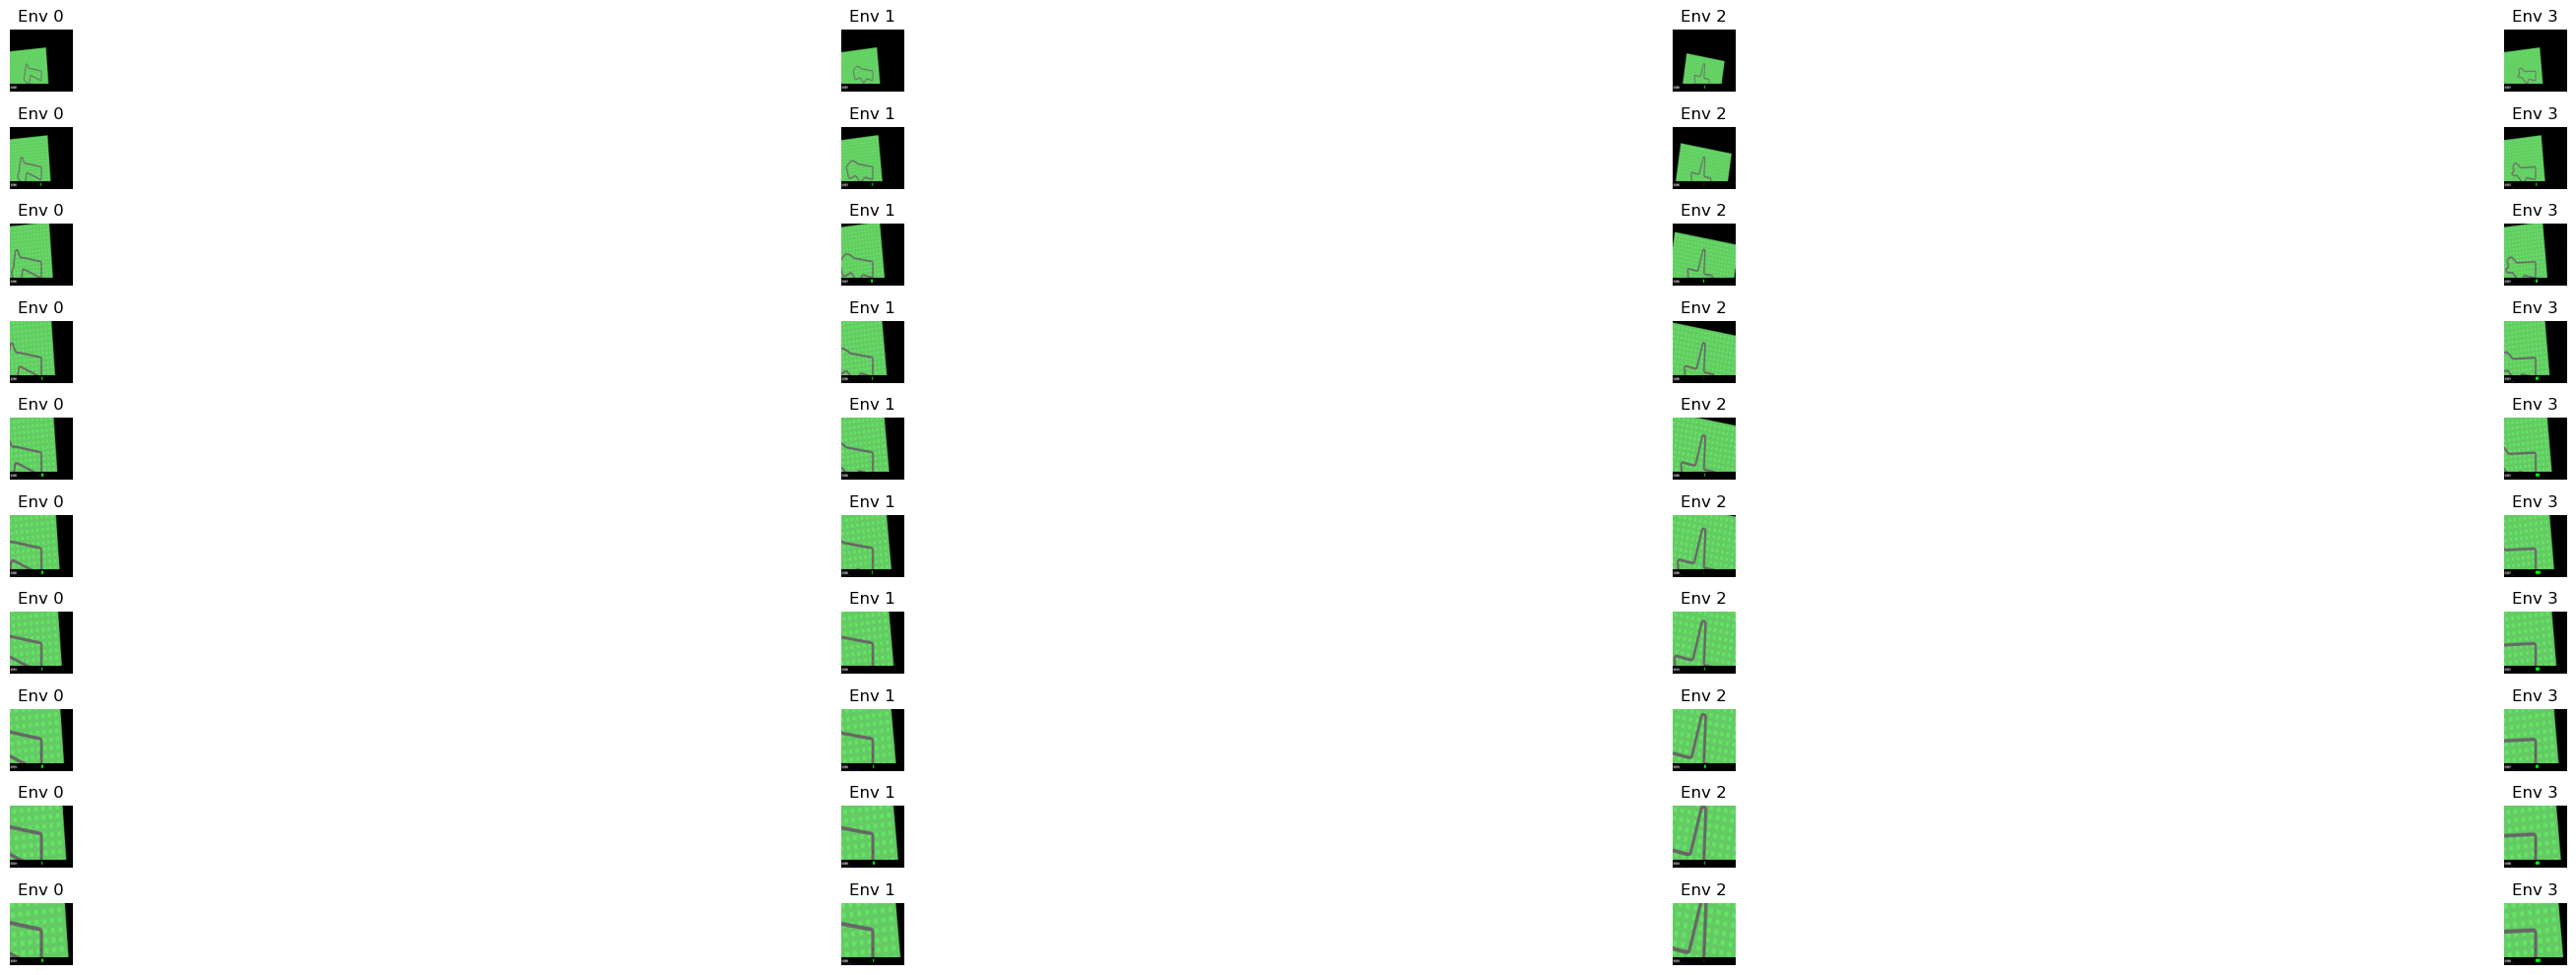

In [26]:
obs = rb.obs.cpu().numpy()  # shape: (n_env, 96, 96, 3)

n_env = obs.shape[1]
n= obs.shape[0]
fig, axes = plt.subplots(n, n_env, figsize=(n_env * 10, 10))

for j in range(n):
    for i in range(n_env):
        axes[j,i].imshow(obs[j,i].astype(np.uint8))
        axes[j,i].set_title(f"Env {i}")
        axes[j,i].axis('off')

plt.tight_layout()
plt.show()

In [15]:
#Test environment
test_env= gym.make("CarRacing-v3", render_mode="human",  lap_complete_percent= 0.95, max_episode_steps= 4000)
test_obs, _= test_env.reset(options={"randomize": False})
ret=0
for i in range(2000):
    test_env.render()
    test_act, _, _= action_sampler(AC, test_obs, hyper.num_envs)
    test_next_obs, test_reward, test_done, _, _ = test_env.step(np.squeeze(test_act))
    test_obs= test_next_obs
test_env.close()